In [1]:
# Load packages
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import OrdinalEncoder, OneHotEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from pathlib import Path
import shared_functions as sf

In [2]:
# Define model & file name
model_name = 'MLPModel_BatchNorm'
file_name = 'property-sales_new-york-city_2022_pre-processed'

In [3]:
# Create output directory for exports
Path(f'../models/{model_name}').mkdir(parents=True, exist_ok=True)

In [4]:
# Load subset keys as list
subset_keys = pd.read_csv(f'../data/processed/subset_keys.csv').squeeze().to_list()

In [5]:
# Load subset index as series
subset_index = pd.read_csv(f'../data/processed/subset_index.csv', index_col=0)

In [6]:
# Use GPU when possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type
print(f'Device type: {device.upper()}')

Device type: CPU


In [7]:
# Set random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [8]:
dataset_params = {
    'data': f'../data/processed/{file_name}.parquet',
    'target_name': 'sale_price',
    'to_drop': 'sale_price_adj',
    'subset_index': '../data/processed/subset_index.csv',
    'input_scaler': StandardScaler(),
    'target_scaler': None,
    'categorical_encoder': TargetEncoder(),
    'numerical_imputer': SimpleImputer(missing_values=pd.NA, strategy='mean'),
    'data_overview': f'../data/processed/{file_name}_data-overview.csv'
    }

In [9]:
# Instantiate datasets
subsets = {subset_key: sf.MultiModalDataset(**dataset_params, subset=subset_key) for subset_key in subset_keys}
dataset = sf.MultiModalDataset(**dataset_params)

In [10]:
# Define model architecture
class MLPModel_BatchNorm(nn.Module):
    # Define model components
    def __init__(self):
        super().__init__()

        # Define text model
        self.TextModel = nn.Sequential(
            nn.Linear(dataset.X_text.shape[1], 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 1)
            )

    # Define forward pass
    def forward(self, X_text):
        y = self.TextModel(X_text)
        return y

In [11]:
# Instantiate model
model = MLPModel_BatchNorm().to(device)

In [12]:
# Calculate number of model parameters
n_params = sum(parameter.numel() for parameter in model.parameters())
print(f'# model paramters: {n_params}')

# model paramters: 5313


In [13]:
# # Do not train if already trained
# if Path(f'../models/{model_name}/state_dict.pt').is_file() and Path(f'../models/{model_name}/history.csv').is_file():
#     # Load optimal weights and history
#     model.load_state_dict(torch.load(f'../models/{model_name}/state_dict.pt'))
#     history = pd.read_csv(f'../models/{model_name}/history.csv', index_col=0)
#     print('Skipping training and loading optimal weights from previous training!')
# else:
# Train model
model, history = sf.train_model(
    model=model,
    dataset_train=subsets['train'],
    dataset_val=subsets['val'],

    # Define loss & optimizer
    loss_function=nn.MSELoss().to(device),
    optimizer=optim.Adam(params=model.parameters(), lr=.001),

    # Define computing device
    device=device,

    # Define training parameters
    epochs=200,
    patience=200,
    delta=0,
    batch_size=64,
    shuffle=True,
    num_workers=0,
    pin_memory=True,

    # Define save locations
    save_state_dict_as=f'../models/{model_name}/state_dict.pt',
    save_history_as=f'../models/{model_name}/history.csv'
    )

100%|██████████| 646/646 [00:01<00:00, 441.82it/s]


Epoch   1/100: RMSE_train: 1,732,875, RMSE_val: 1,735,950


100%|██████████| 646/646 [00:01<00:00, 449.12it/s]


Epoch   2/100: RMSE_train: 1,724,467, RMSE_val: 1,721,418


100%|██████████| 646/646 [00:01<00:00, 450.53it/s]


Epoch   3/100: RMSE_train: 1,708,752, RMSE_val: 1,706,157


100%|██████████| 646/646 [00:01<00:00, 453.18it/s]


Epoch   4/100: RMSE_train: 1,687,176, RMSE_val: 1,702,829


100%|██████████| 646/646 [00:01<00:00, 452.48it/s]


Epoch   5/100: RMSE_train: 1,660,668, RMSE_val: 1,676,710


100%|██████████| 646/646 [00:01<00:00, 450.66it/s]


Epoch   6/100: RMSE_train: 1,630,146, RMSE_val: 1,644,763


100%|██████████| 646/646 [00:01<00:00, 452.93it/s]


Epoch   7/100: RMSE_train: 1,595,304, RMSE_val: 1,631,865


100%|██████████| 646/646 [00:01<00:00, 454.58it/s]


Epoch   8/100: RMSE_train: 1,557,129, RMSE_val: 1,596,318


100%|██████████| 646/646 [00:01<00:00, 449.98it/s]


Epoch   9/100: RMSE_train: 1,515,653, RMSE_val: 1,560,794


100%|██████████| 646/646 [00:01<00:00, 451.32it/s]


Epoch  10/100: RMSE_train: 1,470,944, RMSE_val: 1,537,624


100%|██████████| 646/646 [00:01<00:00, 440.25it/s]


Epoch  11/100: RMSE_train: 1,423,728, RMSE_val: 1,502,773


100%|██████████| 646/646 [00:01<00:00, 403.92it/s]


Epoch  12/100: RMSE_train: 1,373,801, RMSE_val: 1,510,103
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:01<00:00, 450.93it/s]


Epoch  13/100: RMSE_train: 1,319,984, RMSE_val: 1,675,352
EarlyStopping counter: 2 out of 100


100%|██████████| 646/646 [00:01<00:00, 442.32it/s]


Epoch  14/100: RMSE_train: 1,264,963, RMSE_val: 2,816,084
EarlyStopping counter: 3 out of 100


100%|██████████| 646/646 [00:01<00:00, 440.50it/s]


Epoch  15/100: RMSE_train: 1,210,143, RMSE_val: 3,112,700
EarlyStopping counter: 4 out of 100


100%|██████████| 646/646 [00:01<00:00, 453.71it/s]


Epoch  16/100: RMSE_train: 1,151,643, RMSE_val: 1,347,783


100%|██████████| 646/646 [00:01<00:00, 454.84it/s]


Epoch  17/100: RMSE_train: 1,090,579, RMSE_val: 1,707,601
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:01<00:00, 453.21it/s]


Epoch  18/100: RMSE_train: 1,031,013, RMSE_val: 1,237,527


100%|██████████| 646/646 [00:01<00:00, 448.49it/s]


Epoch  19/100: RMSE_train: 973,242, RMSE_val: 1,252,173
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:01<00:00, 436.88it/s]


Epoch  20/100: RMSE_train: 914,074, RMSE_val: 1,318,236
EarlyStopping counter: 2 out of 100


100%|██████████| 646/646 [00:01<00:00, 445.10it/s]


Epoch  21/100: RMSE_train: 854,128, RMSE_val: 1,879,966
EarlyStopping counter: 3 out of 100


100%|██████████| 646/646 [00:01<00:00, 452.03it/s]


Epoch  22/100: RMSE_train: 798,187, RMSE_val: 1,933,513
EarlyStopping counter: 4 out of 100


100%|██████████| 646/646 [00:01<00:00, 412.21it/s]


Epoch  23/100: RMSE_train: 748,013, RMSE_val: 3,837,296
EarlyStopping counter: 5 out of 100


100%|██████████| 646/646 [00:01<00:00, 443.55it/s]


Epoch  24/100: RMSE_train: 698,491, RMSE_val: 1,068,167


100%|██████████| 646/646 [00:01<00:00, 449.82it/s]


Epoch  25/100: RMSE_train: 653,820, RMSE_val: 1,511,043
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:01<00:00, 451.93it/s]


Epoch  26/100: RMSE_train: 618,768, RMSE_val: 1,096,614
EarlyStopping counter: 2 out of 100


100%|██████████| 646/646 [00:01<00:00, 429.93it/s]


Epoch  27/100: RMSE_train: 585,394, RMSE_val: 1,032,855


100%|██████████| 646/646 [00:01<00:00, 451.94it/s]


Epoch  28/100: RMSE_train: 572,420, RMSE_val: 1,032,107


100%|██████████| 646/646 [00:01<00:00, 453.30it/s]


Epoch  29/100: RMSE_train: 551,949, RMSE_val: 1,036,573
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:01<00:00, 450.46it/s]


Epoch  30/100: RMSE_train: 545,337, RMSE_val: 1,028,552


100%|██████████| 646/646 [00:01<00:00, 446.12it/s]


Epoch  31/100: RMSE_train: 546,524, RMSE_val: 1,040,814
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:01<00:00, 450.80it/s]


Epoch  32/100: RMSE_train: 538,780, RMSE_val: 1,036,926
EarlyStopping counter: 2 out of 100


100%|██████████| 646/646 [00:01<00:00, 449.75it/s]


Epoch  33/100: RMSE_train: 534,310, RMSE_val: 1,038,136
EarlyStopping counter: 3 out of 100


100%|██████████| 646/646 [00:01<00:00, 450.11it/s]


Epoch  34/100: RMSE_train: 537,080, RMSE_val: 1,080,062
EarlyStopping counter: 4 out of 100


100%|██████████| 646/646 [00:01<00:00, 452.60it/s]


Epoch  35/100: RMSE_train: 530,503, RMSE_val: 1,021,473


100%|██████████| 646/646 [00:01<00:00, 451.59it/s]


Epoch  36/100: RMSE_train: 523,339, RMSE_val: 1,025,456
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:01<00:00, 448.92it/s]


Epoch  37/100: RMSE_train: 522,558, RMSE_val: 1,061,920
EarlyStopping counter: 2 out of 100


100%|██████████| 646/646 [00:01<00:00, 448.85it/s]


Epoch  38/100: RMSE_train: 519,124, RMSE_val: 1,033,373
EarlyStopping counter: 3 out of 100


100%|██████████| 646/646 [00:01<00:00, 447.91it/s]


Epoch  39/100: RMSE_train: 510,047, RMSE_val: 1,033,359
EarlyStopping counter: 4 out of 100


100%|██████████| 646/646 [00:01<00:00, 450.02it/s]


Epoch  40/100: RMSE_train: 513,253, RMSE_val: 1,015,671


100%|██████████| 646/646 [00:01<00:00, 450.72it/s]


Epoch  41/100: RMSE_train: 512,529, RMSE_val: 1,011,254


100%|██████████| 646/646 [00:01<00:00, 457.55it/s]


Epoch  42/100: RMSE_train: 517,475, RMSE_val: 1,032,608
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:01<00:00, 452.77it/s]


Epoch  43/100: RMSE_train: 511,623, RMSE_val: 1,054,355
EarlyStopping counter: 2 out of 100


100%|██████████| 646/646 [00:01<00:00, 456.58it/s]


Epoch  44/100: RMSE_train: 504,557, RMSE_val: 4,701,820
EarlyStopping counter: 3 out of 100


100%|██████████| 646/646 [00:01<00:00, 449.47it/s]


Epoch  45/100: RMSE_train: 496,885, RMSE_val: 1,046,817
EarlyStopping counter: 4 out of 100


100%|██████████| 646/646 [00:01<00:00, 451.56it/s]


Epoch  46/100: RMSE_train: 500,877, RMSE_val: 1,027,227
EarlyStopping counter: 5 out of 100


100%|██████████| 646/646 [00:01<00:00, 442.95it/s]


Epoch  47/100: RMSE_train: 499,542, RMSE_val: 1,035,429
EarlyStopping counter: 6 out of 100


100%|██████████| 646/646 [00:01<00:00, 438.96it/s]


Epoch  48/100: RMSE_train: 495,860, RMSE_val: 1,048,750
EarlyStopping counter: 7 out of 100


100%|██████████| 646/646 [00:01<00:00, 412.32it/s]


Epoch  49/100: RMSE_train: 503,084, RMSE_val: 992,310


100%|██████████| 646/646 [00:01<00:00, 446.90it/s]


Epoch  50/100: RMSE_train: 497,024, RMSE_val: 1,049,720
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:01<00:00, 433.73it/s]


Epoch  51/100: RMSE_train: 502,700, RMSE_val: 1,046,960
EarlyStopping counter: 2 out of 100


100%|██████████| 646/646 [00:01<00:00, 447.74it/s]


Epoch  52/100: RMSE_train: 488,125, RMSE_val: 1,036,255
EarlyStopping counter: 3 out of 100


100%|██████████| 646/646 [00:01<00:00, 443.18it/s]


Epoch  53/100: RMSE_train: 492,955, RMSE_val: 1,011,019
EarlyStopping counter: 4 out of 100


100%|██████████| 646/646 [00:01<00:00, 441.34it/s]


Epoch  54/100: RMSE_train: 488,102, RMSE_val: 1,041,938
EarlyStopping counter: 5 out of 100


100%|██████████| 646/646 [00:01<00:00, 442.63it/s]


Epoch  55/100: RMSE_train: 484,046, RMSE_val: 1,149,078
EarlyStopping counter: 6 out of 100


100%|██████████| 646/646 [00:01<00:00, 450.47it/s]


Epoch  56/100: RMSE_train: 489,226, RMSE_val: 1,041,456
EarlyStopping counter: 7 out of 100


100%|██████████| 646/646 [00:01<00:00, 418.84it/s]


Epoch  57/100: RMSE_train: 484,557, RMSE_val: 1,025,843
EarlyStopping counter: 8 out of 100


100%|██████████| 646/646 [00:01<00:00, 451.69it/s]


Epoch  58/100: RMSE_train: 485,578, RMSE_val: 1,030,763
EarlyStopping counter: 9 out of 100


100%|██████████| 646/646 [00:01<00:00, 443.84it/s]


Epoch  59/100: RMSE_train: 487,915, RMSE_val: 8,809,881
EarlyStopping counter: 10 out of 100


100%|██████████| 646/646 [00:01<00:00, 448.29it/s]


Epoch  60/100: RMSE_train: 485,981, RMSE_val: 1,133,672
EarlyStopping counter: 11 out of 100


100%|██████████| 646/646 [00:01<00:00, 452.25it/s]


Epoch  61/100: RMSE_train: 500,634, RMSE_val: 1,065,796
EarlyStopping counter: 12 out of 100


100%|██████████| 646/646 [00:01<00:00, 451.04it/s]


Epoch  62/100: RMSE_train: 494,851, RMSE_val: 3,226,375
EarlyStopping counter: 13 out of 100


100%|██████████| 646/646 [00:01<00:00, 450.30it/s]


Epoch  63/100: RMSE_train: 490,262, RMSE_val: 2,163,250
EarlyStopping counter: 14 out of 100


100%|██████████| 646/646 [00:01<00:00, 450.18it/s]


Epoch  64/100: RMSE_train: 488,075, RMSE_val: 4,019,253
EarlyStopping counter: 15 out of 100


100%|██████████| 646/646 [00:01<00:00, 452.18it/s]


Epoch  65/100: RMSE_train: 482,971, RMSE_val: 1,051,345
EarlyStopping counter: 16 out of 100


100%|██████████| 646/646 [00:01<00:00, 452.82it/s]


Epoch  66/100: RMSE_train: 490,588, RMSE_val: 1,039,806
EarlyStopping counter: 17 out of 100


100%|██████████| 646/646 [00:01<00:00, 452.20it/s]


Epoch  67/100: RMSE_train: 486,212, RMSE_val: 1,048,523
EarlyStopping counter: 18 out of 100


100%|██████████| 646/646 [00:01<00:00, 449.32it/s]


Epoch  68/100: RMSE_train: 490,624, RMSE_val: 1,034,384
EarlyStopping counter: 19 out of 100


100%|██████████| 646/646 [00:01<00:00, 452.55it/s]


Epoch  69/100: RMSE_train: 485,023, RMSE_val: 1,039,986
EarlyStopping counter: 20 out of 100


100%|██████████| 646/646 [00:01<00:00, 418.76it/s]


Epoch  70/100: RMSE_train: 484,137, RMSE_val: 1,044,365
EarlyStopping counter: 21 out of 100


100%|██████████| 646/646 [00:01<00:00, 449.70it/s]


Epoch  71/100: RMSE_train: 481,387, RMSE_val: 1,026,911
EarlyStopping counter: 22 out of 100


100%|██████████| 646/646 [00:01<00:00, 447.18it/s]


Epoch  72/100: RMSE_train: 480,787, RMSE_val: 1,039,990
EarlyStopping counter: 23 out of 100


100%|██████████| 646/646 [00:01<00:00, 449.32it/s]


Epoch  73/100: RMSE_train: 485,641, RMSE_val: 15,006,172
EarlyStopping counter: 24 out of 100


100%|██████████| 646/646 [00:01<00:00, 447.90it/s]


Epoch  74/100: RMSE_train: 486,292, RMSE_val: 1,033,086
EarlyStopping counter: 25 out of 100


100%|██████████| 646/646 [00:01<00:00, 443.82it/s]


Epoch  75/100: RMSE_train: 485,354, RMSE_val: 1,067,174
EarlyStopping counter: 26 out of 100


100%|██████████| 646/646 [00:01<00:00, 448.61it/s]


Epoch  76/100: RMSE_train: 479,698, RMSE_val: 1,053,228
EarlyStopping counter: 27 out of 100


100%|██████████| 646/646 [00:01<00:00, 447.94it/s]


Epoch  77/100: RMSE_train: 482,161, RMSE_val: 1,057,005
EarlyStopping counter: 28 out of 100


100%|██████████| 646/646 [00:01<00:00, 436.64it/s]


Epoch  78/100: RMSE_train: 479,833, RMSE_val: 1,040,288
EarlyStopping counter: 29 out of 100


100%|██████████| 646/646 [00:01<00:00, 389.95it/s]


Epoch  79/100: RMSE_train: 493,348, RMSE_val: 1,575,340
EarlyStopping counter: 30 out of 100


100%|██████████| 646/646 [00:01<00:00, 449.66it/s]


Epoch  80/100: RMSE_train: 483,550, RMSE_val: 1,090,307
EarlyStopping counter: 31 out of 100


100%|██████████| 646/646 [00:01<00:00, 452.20it/s]


Epoch  81/100: RMSE_train: 480,475, RMSE_val: 1,062,870
EarlyStopping counter: 32 out of 100


100%|██████████| 646/646 [00:01<00:00, 449.29it/s]


Epoch  82/100: RMSE_train: 474,672, RMSE_val: 1,041,174
EarlyStopping counter: 33 out of 100


100%|██████████| 646/646 [00:01<00:00, 450.87it/s]


Epoch  83/100: RMSE_train: 478,040, RMSE_val: 1,065,234
EarlyStopping counter: 34 out of 100


100%|██████████| 646/646 [00:01<00:00, 449.49it/s]


Epoch  84/100: RMSE_train: 473,409, RMSE_val: 1,045,663
EarlyStopping counter: 35 out of 100


100%|██████████| 646/646 [00:01<00:00, 451.95it/s]


Epoch  85/100: RMSE_train: 477,434, RMSE_val: 1,050,794
EarlyStopping counter: 36 out of 100


100%|██████████| 646/646 [00:01<00:00, 452.71it/s]


Epoch  86/100: RMSE_train: 488,845, RMSE_val: 49,317,231
EarlyStopping counter: 37 out of 100


100%|██████████| 646/646 [00:01<00:00, 452.40it/s]


Epoch  87/100: RMSE_train: 504,214, RMSE_val: 19,227,867
EarlyStopping counter: 38 out of 100


100%|██████████| 646/646 [00:01<00:00, 451.40it/s]


Epoch  88/100: RMSE_train: 492,401, RMSE_val: 1,457,737
EarlyStopping counter: 39 out of 100


100%|██████████| 646/646 [00:01<00:00, 452.05it/s]


Epoch  89/100: RMSE_train: 483,776, RMSE_val: 52,493,442
EarlyStopping counter: 40 out of 100


100%|██████████| 646/646 [00:01<00:00, 452.65it/s]


Epoch  90/100: RMSE_train: 492,120, RMSE_val: 3,719,566
EarlyStopping counter: 41 out of 100


100%|██████████| 646/646 [00:01<00:00, 425.03it/s]


Epoch  91/100: RMSE_train: 481,362, RMSE_val: 56,802,469
EarlyStopping counter: 42 out of 100


100%|██████████| 646/646 [00:01<00:00, 451.44it/s]


Epoch  92/100: RMSE_train: 477,852, RMSE_val: 1,980,396
EarlyStopping counter: 43 out of 100


100%|██████████| 646/646 [00:01<00:00, 450.95it/s]


Epoch  93/100: RMSE_train: 475,995, RMSE_val: 1,100,932
EarlyStopping counter: 44 out of 100


100%|██████████| 646/646 [00:01<00:00, 452.16it/s]


Epoch  94/100: RMSE_train: 478,528, RMSE_val: 4,243,312
EarlyStopping counter: 45 out of 100


100%|██████████| 646/646 [00:01<00:00, 451.24it/s]


Epoch  95/100: RMSE_train: 481,789, RMSE_val: 134,729,911
EarlyStopping counter: 46 out of 100


100%|██████████| 646/646 [00:01<00:00, 449.65it/s]


Epoch  96/100: RMSE_train: 480,112, RMSE_val: 82,458,260
EarlyStopping counter: 47 out of 100


100%|██████████| 646/646 [00:01<00:00, 451.42it/s]


Epoch  97/100: RMSE_train: 476,302, RMSE_val: 84,828,091
EarlyStopping counter: 48 out of 100


100%|██████████| 646/646 [00:01<00:00, 451.31it/s]


Epoch  98/100: RMSE_train: 479,931, RMSE_val: 87,769,969
EarlyStopping counter: 49 out of 100


100%|██████████| 646/646 [00:01<00:00, 451.10it/s]


Epoch  99/100: RMSE_train: 476,521, RMSE_val: 1,509,376
EarlyStopping counter: 50 out of 100


100%|██████████| 646/646 [00:01<00:00, 447.69it/s]

Epoch 100/100: RMSE_train: 479,194, RMSE_val: 8,156,783
EarlyStopping counter: 51 out of 100


In [14]:
# Generate model predictions
predictions = sf.get_predictions(model, dataset, subset_index, device, save_as=f'../models/{model_name}/predictions.csv')

In [15]:
# Compute performance metrics
metrics = sf.get_metrics(predictions, subset_keys, save_as=f'../models/{model_name}/perf_metrics.csv')

Subset         RMSE         MAE   MAPE     R2
---------------------------------------------
train    474988.204  272903.930  0.461  0.855
val      995247.520  612973.988  0.958  0.354
test    1006158.673  611717.423  0.915  0.346
---------------------------------------------
total    677821.537  374669.032  0.601  0.704


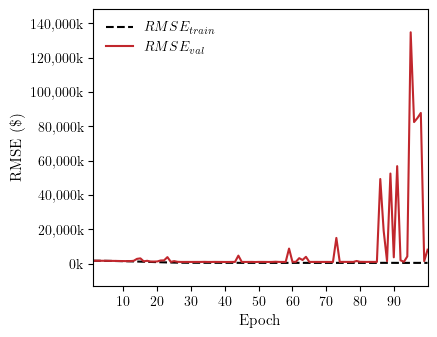

In [16]:
# Plot training history
sf.plot_history(history, save_as=f'../models/{model_name}/history.pdf')

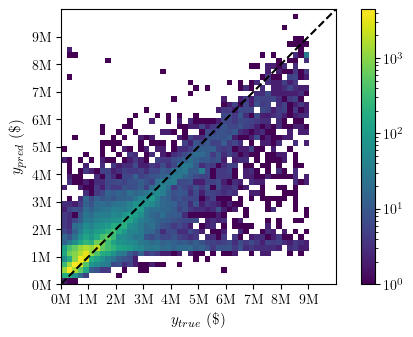

In [17]:
# Plot predictions vs actuals
sf.plot_pred_vs_actual(predictions, save_as=f'../models/{model_name}/predictions_vs_actuals.pdf')